In [28]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import zipfile
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from matplotlib_venn import venn3

In [30]:
os.makedirs('database', exist_ok=True)

if not os.path.exists('database/data.rar'):
    !curl https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip -o database/data.rar

if not os.path.exists('database/UCI HAR Dataset.zip'):
    with zipfile.ZipFile('database/data.rar', 'r') as zip_ref:
        zip_ref.extractall('database/')

if not os.path.exists('database/UCI HAR Dataset'):
    with zipfile.ZipFile('database/UCI HAR Dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('database/')


In [31]:
path_labels = './database/UCI HAR Dataset/features.txt'
path_categories = './database/UCI HAR Dataset/activity_labels.txt'
path_x_train = './database/UCI HAR Dataset/train/X_train.txt'
path_y_train = './database/UCI HAR Dataset/train/y_train.txt'
path_x_test = './database/UCI HAR Dataset/test/X_test.txt'
path_y_test = './database/UCI HAR Dataset/test/y_test.txt'

# Treinamento e Test

In [32]:
labels = []
categorias = []
dados_train_x = []
dados_train_y = []

with open(path_x_train, 'r') as f:
    dados_train_x = [line.strip().split() for line in f.readlines()]
    
with open(path_y_train, 'r') as f:
    dados_train_y = [line.strip() for line in f.readlines()]
    
with open(path_x_test, 'r') as f:
    dados_test_x = [line.strip().split() for line in f.readlines()]

with open(path_y_test, 'r') as f:
    dados_test_y = [line.strip() for line in f.readlines()]

with open(path_labels, 'r') as f:
    labels = [line.strip().split()[1] for line in f.readlines()]
    
with open(path_categories, 'r') as f:
    categorias = [line.strip().split()[1] for line in f.readlines()]

labels.__len__(), dados_train_x.__len__(), dados_train_y.__len__(), dados_test_x.__len__(), dados_test_y.__len__(), categorias.__len__()

(561, 7352, 7352, 2947, 2947, 6)

In [33]:
dataframe_x_train = pd.DataFrame(dados_train_x, columns=labels)
dataframe_x_test = pd.DataFrame(dados_test_x, columns=labels)
dataframe_x_train.shape, dataframe_x_test.shape

((7352, 561), (2947, 561))

In [34]:
dataframe_y_train = pd.DataFrame(dados_train_y, columns=['Resultado'])
dataframe_y_test = pd.DataFrame(dados_test_y, columns=['Resultado'])
dataframe_y_train.shape, dataframe_y_test.shape

((7352, 1), (2947, 1))

In [35]:
dataframe_x_train = dataframe_x_train.astype('float64')
dataframe_x_test = dataframe_x_test.astype('float64')
dataframe_y_train = dataframe_y_train.astype('int64')
dataframe_y_test = dataframe_y_test.astype('int64')

# Scaler

In [36]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(dataframe_x_train)
X_scaled_test = scaler.transform(dataframe_x_test)

In [37]:
X_scaled_train.std(), X_scaled_test.std()

(np.float64(1.0), np.float64(0.9289333099557896))

# PCA

In [38]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_train)
var_explicada = pca.explained_variance_ratio_

print("Variância explicada por cada componente:", var_explicada)
print("Variância total explicada:", var_explicada.sum())

Variância explicada por cada componente: [0.50781172 0.0658068 ]
Variância total explicada: 0.5736185255809917


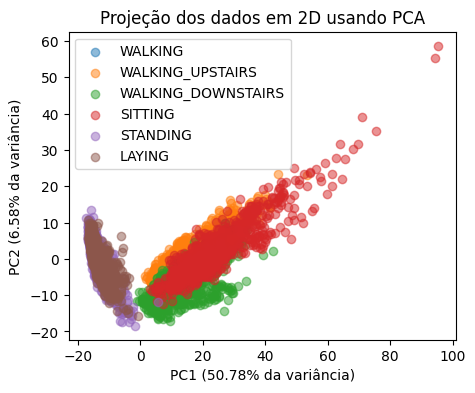

In [39]:
plt.figure(figsize=(5,4))

for i, categoria in enumerate(categorias):
    indices = dataframe_y_train['Resultado'] == i
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=categoria, alpha=0.5)

plt.legend()
plt.xlabel(f"PC1 ({var_explicada[0]*100:.2f}% da variância)")
plt.ylabel(f"PC2 ({var_explicada[1]*100:.2f}% da variância)")
plt.title("Projeção dos dados em 2D usando PCA")
plt.show()


In [40]:
pca_full = PCA()
pca_full.fit(X_scaled_train)

variancia_acumulada = pca_full.explained_variance_ratio_.cumsum()
componentes_90 = np.argmax(variancia_acumulada >= 0.90) + 1

print(f"Número de componentes necessários para 90% da variância: {componentes_90}")
print(f"Variância explicada com {componentes_90} componentes: {variancia_acumulada[componentes_90-1]:.4f}")

Número de componentes necessários para 90% da variância: 63
Variância explicada com 63 componentes: 0.9005


In [41]:
dframe_features = pd.DataFrame({
    'Variância Explicada': pca_full.explained_variance_ratio_,
})
dframe_features[:5]

,Variância Explicada
0,0.507812
1,0.065807
2,0.028064
3,0.025040
4,0.018883


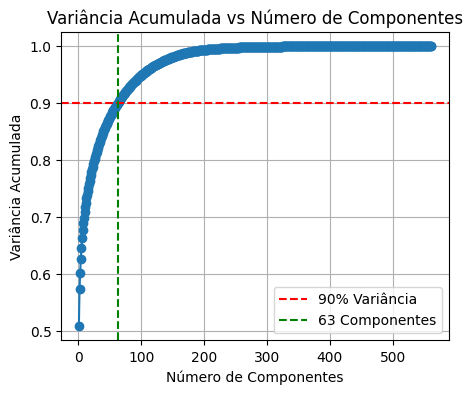

In [42]:
plt.figure(figsize=(5,4))
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variância')
plt.axvline(x=componentes_90, color='g', linestyle='--', label=f'{componentes_90} Componentes')
plt.title('Variância Acumulada vs Número de Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')
plt.legend()
plt.grid()
plt.show()

# RFE

In [43]:
x_train = X_scaled_train
y_train = dataframe_y_train.values.ravel()

x_test = X_scaled_test
y_test = dataframe_y_test.values.ravel()

In [44]:
model_logist = LogisticRegression(max_iter=1000)
model_rand = RandomForestClassifier()

if not os.path.exists('rfe_model_logist.pkl'):
  rfe_logist = RFE(estimator=model_logist, n_features_to_select=1, step=1, verbose=0)
  rfe_logist.fit(x_train, y_train);

  with open('rfe_model_logist.pkl', 'wb') as f:
      pickle.dump(rfe_logist, f)
else:
  with open('rfe_model_logist.pkl', 'rb') as f:
      rfe_logist = pickle.load(f)
      
if not os.path.exists('rfe_model_rand.pkl'):
  rfe_random = RFE(estimator=model_rand, n_features_to_select=1, step=1, verbose=1)
  rfe_random.fit(x_train, y_train);

  with open('rfe_model_rand.pkl', 'wb') as f:
      pickle.dump(rfe_random, f)
else:
  with open('rfe_model_rand.pkl', 'rb') as f:
      rfe_random = pickle.load(f)

In [45]:
df_rfe_ranking = pd.DataFrame({
    "label": dataframe_x_train.columns,
    "RFE_logist_Ranking": rfe_logist.ranking_,
}).sort_values(by="RFE_logist_Ranking").set_index("label")
df_rfe_ranking.head(10)

,RFE_logist_Ranking
label,
tGravityAcc-min()-X,1
fBodyAccJerk-entropy()-X,2
tGravityAcc-energy()-Y,3
tBodyAccJerk-entropy()-X,4
tBodyAccJerk-entropy()-Z,5
fBodyAccMag-energy(),6
tGravityAcc-mean()-Y,7
tBodyGyro-iqr()-Y,8
fBodyGyro-entropy()-X,9


In [46]:
df_rfe_ranking = pd.DataFrame({
    "label": dataframe_x_train.columns,
    "RFE_rand_Ranking": rfe_random.ranking_
}).sort_values(by="RFE_rand_Ranking").set_index("label")
df_rfe_ranking.head(10)

,RFE_rand_Ranking
label,
"angle(Y,gravityMean)",1
fBodyAcc-mad()-X,2
tGravityAcc-min()-X,3
tGravityAcc-mean()-X,4
"fBodyAccJerk-bandsEnergy()-1,8",5
fBodyAccMag-mad(),6
tGravityAcc-energy()-X,7
"tGravityAcc-arCoeff()-Z,1",8
tGravityAcc-mean()-Y,9


In [47]:
df_rfe_ranking = pd.DataFrame({
    "label": dataframe_x_train.columns,
    "RFE_logist_Ranking": rfe_logist.ranking_,
    "RFE_rand_Ranking": rfe_random.ranking_
}).sort_values(by="RFE_logist_Ranking").set_index("label")
df_rfe_ranking.head(10)

,RFE_logist_Ranking,RFE_rand_Ranking
label,,
tGravityAcc-min()-X,1,3
fBodyAccJerk-entropy()-X,2,424
tGravityAcc-energy()-Y,3,28
tBodyAccJerk-entropy()-X,4,57
tBodyAccJerk-entropy()-Z,5,120
fBodyAccMag-energy(),6,14
tGravityAcc-mean()-Y,7,9
tBodyGyro-iqr()-Y,8,142
fBodyGyro-entropy()-X,9,112


## Performance por numero de atributos rfe

In [48]:
scores = []

for k in range(1, componentes_90 + 1, 10):
    x_train_selected_logist = x_train[:, rfe_logist.ranking_ <= k]
    x_train_selected_rand = x_train[:, rfe_random.ranking_ <= k]

    model_test_logic = LogisticRegression(max_iter=1000)
    model_test_logic.fit(x_train_selected_logist, y_train)
    
    model_test_rand = RandomForestClassifier()
    model_test_rand.fit(x_train_selected_rand, y_train)
    
    x_test_selected_logist = x_test[:, rfe_logist.ranking_ <= k]
    x_test_selected_rand = x_test[:, rfe_random.ranking_ <= k]

    acc_logic = model_test_logic.score(x_test_selected_logist, y_test)
    acc_rand = model_test_rand.score(x_test_selected_rand, y_test)

    print(f'k={k}: Logistic Regression Accuracy={acc_logic:.4f}, Random Forest Accuracy={acc_rand:.4f}')
    scores.append((k, acc_logic, acc_rand))
    

k=1: Logistic Regression Accuracy=0.3987, Random Forest Accuracy=0.3960
k=11: Logistic Regression Accuracy=0.8663, Random Forest Accuracy=0.8232
k=21: Logistic Regression Accuracy=0.9213, Random Forest Accuracy=0.8402
k=31: Logistic Regression Accuracy=0.9321, Random Forest Accuracy=0.8605
k=41: Logistic Regression Accuracy=0.9365, Random Forest Accuracy=0.8694
k=51: Logistic Regression Accuracy=0.9389, Random Forest Accuracy=0.8945
k=61: Logistic Regression Accuracy=0.9488, Random Forest Accuracy=0.9077


In [49]:
scores_df = pd.DataFrame(scores, columns=['Número de Features', 'Acurácia Logistic Regression', 'Acurácia Random Forest'])
scores_df

,Número de Features,Acurácia Logistic Regression,Acurácia Random Forest
0,1,0.398711,0.395996
1,11,0.866305,0.823210
2,21,0.921276,0.840176
3,31,0.932134,0.860536
4,41,0.936546,0.869359
5,51,0.938921,0.894469
6,61,0.948761,0.907703


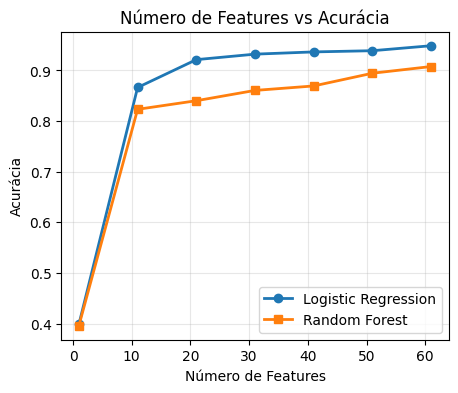

In [50]:
plt.figure(figsize=(5, 4))
plt.plot(scores_df['Número de Features'], scores_df['Acurácia Logistic Regression'], marker='o', label='Logistic Regression', linewidth=2)
plt.plot(scores_df['Número de Features'], scores_df['Acurácia Random Forest'], marker='s', label='Random Forest', linewidth=2)
plt.title('Número de Features vs Acurácia')
plt.xlabel('Número de Features')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Lasso

In [58]:
lasso_hyper_params = [0.01, 0.1, 1, 10]
lasso_results = []

for alpha in lasso_hyper_params:
    lasso = Lasso(alpha=alpha) 
    lasso.fit(x_train, y_train)
    selected_features = dataframe_x_train.columns[np.abs(lasso.coef_) > 1e-5]

    lasso_results.append({
        "alpha": alpha,
        "num_features": len(selected_features),
        "score": lasso.score(x_test, y_test),
        "features": list(selected_features)
    })

df_lasso_results = pd.DataFrame(lasso_results)
df_lasso_results

c:\projetos\kaua\Topicos_Especiais_Em_Computacao\2_Trabalho\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.175e+01, tolerance: 2.238e+00
  model = cd_fast.enet_coordinate_descent(


,alpha,num_features,score,features
0,0.01,115,0.943724,"[tBodyAcc-iqr()-Z, tBodyAcc-arCoeff()-X,1, tBo..."
1,0.10,14,0.873302,"[tGravityAcc-min()-X, tBodyAccJerk-entropy()-X..."
2,1.00,2,0.407178,"[tBodyAccJerk-entropy()-X, tBodyAccJerk-entrop..."
3,10.00,0,-0.001416,[]


In [ ]:
df_lasso_results['features'][1] # ou substitua o índice 1 pelo índice desejado (ex. 0, 1, 2, 3)

['tGravityAcc-min()-X',
 'tBodyAccJerk-entropy()-X',
 'tBodyAccJerk-entropy()-Z',
 'tBodyGyroJerk-arCoeff()-X,3',
 'tBodyGyroJerk-correlation()-Y,Z',
 'tBodyAccMag-min()',
 'tGravityAccMag-min()',
 'fBodyAccJerk-max()-Y',
 'fBodyAccJerk-skewness()-Z',
 'fBodyGyro-max()-Y',
 'fBodyGyro-max()-Z',
 'fBodyGyro-meanFreq()-X',
 'fBodyGyro-skewness()-Z',
 'fBodyAccMag-energy()',
 'fBodyBodyGyroMag-maxInds']

## Comparação das variáveis selecionadas

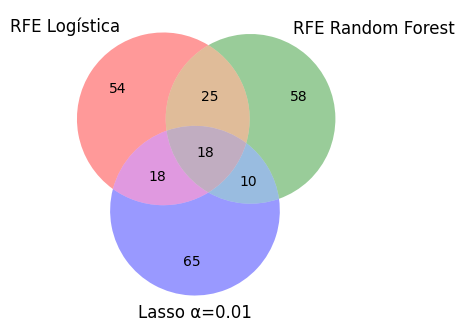

In [ ]:
top_115_features_logist = df_rfe_ranking.nsmallest(115, 'RFE_logist_Ranking').index
top_115_features_rand = df_rfe_ranking.nsmallest(115, 'RFE_rand_Ranking').index
df_lasso_0_01 = pd.Series(lasso_results[0]['features'], name='Lasso_0.01_Features')

set_logist = set(top_115_features_logist)
set_rand = set(top_115_features_rand)
set_lasso = set(df_lasso_0_01)

plt.figure(figsize=(5, 4))
venn3([set_logist, set_rand, set_lasso], set_labels=("RFE Logística", "RFE Random Forest", "Lasso α=0.01"))
plt.show()
